<a href="https://colab.research.google.com/github/explanare/ood-prediction/blob/main/mmlu_ood_prediction_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import getpass
import numpy as np
import os
import random
import sys
import torch


#@markdown **[Run this block]**

#@markdown Set up environment.

#@markdown Set the absolute path to ood-prediction.
project_dir = '/path/to/ood-prediction' #@param
DATA_DIR = f'{project_dir}/data'
MODEL_DIR = f'{project_dir}/models'

sys.path.append(f'{project_dir}/src')
#@markdown Set the Huggingface home/caching dir.
hf_home = '/path/to/hf_home'  #@param
os.environ["HF_HOME"] = hf_home
os.environ["HF_HUB"] = hf_home
os.environ["TRANSFORMERS_CACHE"] = hf_home


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## The Target Model

In our experiment, we are interested in predicting the correctness of outputs from `Llama-3-8B-Instruct`.

In [ ]:
# Llama3 is a gated model. You may need to log in to your HuggingFace account to
# access this model.
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#@markdown **[Run this block]**

#@markdown Load `meta-llama/Meta-Llama-3-8B-Instruct` from HuggingFace Hub.
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer


model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id, low_cpu_mem_usage=True, device_map='auto',
    torch_dtype=torch.bfloat16,
    )
model = model.eval()
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

# The Correctness Prediction Task

We are interested in predicting whether a target model
produces correct answers on a task, espeically on out-of-distribution inputs.

For example, consider the following multiple-choice question from MMLU test set.

```
The following are multiple choice questions (with answers) about abstract algebra.

Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.

A. 0
B. 4
C. 2
D. 6

Answer:
```

If we prompt the target model with this question and the model outputs `B`, how do we know if the model prediction is correct?



---



### Dataset Construction

To formalize this correctness prediction task, we first run behavioral testing on the target model to produce a correctness prediction dataset.

* **ID splits**: Randomly sampled 2048/1024/1024 examples as train/val/test sets from the MMLU test split. For each set, half of the examples are correctly predicted by the target model.

* **OOD splits**: Randomly sampled 512 correct and 512 wrong examples from a modified version of MMLU test split, where either (1) the options (i.e., A, B, C, D) are changed to a different alphabet, or (2) a distracting option E is added to the options.

Below is an OOD example:

```
The following are multiple choice questions (with answers) about abstract algebra.

Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.

Alpha. 0
Beta. 4
Charlie. 2
Delta. 6

Answer:
```


We provide the pre-generated dataset at https://github.com/explanare/ood-prediction/tree/main/data/mmlu_task

# Method I: Confidence Scores

In [ ]:
#@markdown **[Run this block]**

#@markdown Predict correctness using confidence scores.

import collections
import json

import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score
from generation_utils import generate_batched
from metrics import compute_confidence_score, pool_confidence_score, compute_per_token_loss_batched


MMLU_SPLITS = ['in_distribution', 'ood-nato-label', 'ood-e-correct-answer-is-a']

setting_to_metrics = collections.defaultdict(lambda: collections.defaultdict(list))
split_type = 'ood-nato-label' # one of MMLU_SPLITS
task = 'mmlu'  # one of ['mmlu', 'mmlu-mixed]; 'mmlu-mixed' evaluate all splits together without per-split calibration.
split = 'test'
for fold in range(3):
  if task == 'mmlu':
    data_split = json.load(open(os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_{model.name_or_path.split("/")[-1]}_no_chat_template_0shot_{split_type}_split_{fold}.json')))
  elif task == 'mmlu-mixed':
    data_split = json.load(open(os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_{model.name_or_path.split("/")[-1]}_no_chat_template_0shot_{MMLU_SPLITS[0]}_split_{fold}.json')))
    for i in range(1, 3):
      ood_data = json.load(open(os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_{model.name_or_path.split("/")[-1]}_no_chat_template_0shot_{MMLU_SPLITS[i]}_split_{fold}.json')))
      for s in ood_data:
        for k in ood_data[s]:
          data_split[s][k] += ood_data[s][k]
  prompt_to_output = generate_batched(
      model, tokenizer, data_split[split]['correct'] + data_split[split]['wrong'],
      max_new_tokens=1, batch_size=8, top_p=None, top_k=None, temperature=None)
  test_prompt_batch = data_split[split]['correct'] + data_split[split]['wrong']
  test_output_batch = [prompt_to_output[p] for p in test_prompt_batch]
  for temp in np.arange(0.5, 5.0, 0.5):
    confidence_score = compute_confidence_score(
          model, tokenizer, test_prompt_batch, test_output_batch,
          score_fn=lambda x: pool_confidence_score(tokenizer, x, next_n_tokens=1, mode='mean'),
          max_length=512,
          batch_size=8,
          temperature=temp)
    pred_data = pd.DataFrame([{'compare_correct': i < len(data_split[split]['correct']),
                               'top1_confidence': x} for i, x in enumerate(confidence_score)])
    auc_roc = roc_auc_score(pred_data['compare_correct'].tolist(), pred_data['top1_confidence'].tolist())
    setting_to_metrics[temp]['auc_roc'].append(auc_roc)

We first use **in-distribution**, **validation** set to determine the optimal temerpature (i.e., the hyperparameter)

Below are the results. We search in the range of 0.5 to 4.5, which is a broader range than we used in the paper. We see that AUC-ROC peaks at **T=1.5**.

|Temperature| AUC-ROC Mean | STD |
|:-:|:-:|:-:|
| T=0.5	| 0.7963	| 0.0103 |
| T=1.0	| 0.8211	| 0.0066 |
| **T=1.5**	| **0.8220**	| 0.0040 |
| T=2.0	| 0.8139	| 0.0029 |
| T=2.5	| 0.8045	| 0.0032 |
| T=3.0	| 0.8022	| 0.0037 |
| T=3.5	| 0.8022	| 0.0041 |
| T=4.0	| 0.8023	| 0.0040 |

When evaluate on the **in-distribution**, **test set**  split, using the best temperature on validation set, i.e., **T=1.5**, the AUC-ROC is **0.8078**. The full results are below.

|Temperature| AUC-ROC Mean | STD |
|:-:|:-:|:-:|
| T=0.5	| 0.7854	| 0.0102 |
| T=1.0	| 0.8099	| 0.0093 |
| **T=1.5**	| **0.8078**	| 0.0071 |
| T=2.0	| 0.7952	| 0.0017 |
| T=2.5	| 0.7854	| 0.0004 |
| T=3.0	| 0.7834	| 0.0013 |
| T=3.5	| 0.7835	| 0.0011 |
| T=4.0	| 0.7837	| 0.0012 |

In [ ]:
#@markdown **[Run this block]**

#@markdown Now we evaluate on the OOD split. Based on our hyperparameter search results on the validation set, we use **T=1.5**, which yeilds a mean AUC-ROC of **0.747**.

#@markdown We can see the effects of distribution shift on correctness prediction accuracy. The correctness prediction AUC-ROC actually peaks at T=3.5, however, this AUC-ROC is only achievable if we have access to labeled OOD data.

print('Split Name\tTemp\tMean\tSTD')
for t in setting_to_metrics:
  print(split_type, f'T={t}\t' + '%.4f\t%.4f' % (np.mean(setting_to_metrics[t]['auc_roc']), np.std(setting_to_metrics[t]['auc_roc'])))

Split Name	Temp	Mean	STD
ood-nato-label T=0.5	0.6714	0.0233
ood-nato-label T=1.0	0.7071	0.0214
ood-nato-label T=1.5	0.7466	0.0182
ood-nato-label T=2.0	0.7612	0.0165
ood-nato-label T=2.5	0.7627	0.0163
ood-nato-label T=3.0	0.7631	0.0165
ood-nato-label T=3.5	0.7632	0.0167
ood-nato-label T=4.0	0.7630	0.0161
ood-nato-label T=4.5	0.7624	0.0164


# Method II: Counterfactual Simulation

This method is implemented using [pyvene](https://github.com/stanfordnlp/pyvene).

You can download pyvene using

`git clone https://github.com/stanfordnlp/pyvene.git`


In [ ]:
#@markdown **[Run this block]**

#@markdown Once `pyvene` is downloaded, update the absolute path to pyvene below.

import sys

pyvene_abs_path = '/path/to/pyvene' #@param
sys.path.append(pyvene_abs_path)

## Training (Localizing high-level variables)

This section uses Distributed Alignment Search (DAS) to localize the intermediate high-level variable, i.e., a **pointer** to the selected option, on a verified set.

**You can skip to the [inference section](#scrollTo=6i41RAOXQbHO) by using the pre-computed localization results provided in the repo.**

In [ ]:
#@markdown **[Run this block]**

#@markdown Task-specific helper function

CHOICES = ['A', 'B', 'C', 'D']

SYMBOL_MAPPING = {
    c: CHOICES
    for c in CHOICES
}


def extract_prediction(topk_prob):
  choice_to_prob = {}
  for c in CHOICES:
    ans_dist = [x[1] for x in topk_prob if x[0].strip() == c]
    choice_to_prob[c] = sum(ans_dist, 0)
  return sorted(choice_to_prob, key=choice_to_prob.get, reverse=True)[0]

In [ ]:
#@markdown **[Run this block]**

#@markdown Load training data

import json

from causal_data_utils import load_intervention_data, _BASE_TEMPLATE
from generation_utils import generate_batched, generate_distribution_batched

sample_size = 1024
# We only run localization on in-distribution data.
split_type = 'in_distribution'
FOLD_ID = '0' #@param
mode = 'das'
data_split = json.load(open(os.path.join(
    DATA_DIR, 'mmlu_task', f'mmlu_Meta-Llama-3-8B-Instruct_no_chat_template_0shot_in_distribution_split_{FOLD_ID}.json')))
verified_examples = data_split['train']['correct'][:sample_size]
print('Verified Examples:')
print(verified_examples[0])

prompts =  [x for s in data_split for c in data_split[s] for x in data_split[s][c]]
intervention_prompt_to_output = generate_distribution_batched(
      model, tokenizer, prompts, top_k=50)
intervention_prompt_to_output = dict(zip(prompts, intervention_prompt_to_output))
intervention_prompt_to_output = {k: extract_prediction(v) for k, v in intervention_prompt_to_output.items()}
prompt_to_vars = {p: {'input': p,
                      'label': ' ' + intervention_prompt_to_output[p],
                      'split': _BASE_TEMPLATE}
                 for s in data_split for k in ('correct', 'wrong') for p in data_split[s][k]}


def convert_label(base, source):
  base_label = base['label'].strip()
  source_label = source['label'].strip()
  source_index = SYMBOL_MAPPING[source_label].index(source_label)
  return ' ' + SYMBOL_MAPPING[base_label][source_index]


split_to_raw_example, split_to_dataset = load_intervention_data(
    mode, verified_examples, data_split, prompt_to_vars,
    inv_label_fn=convert_label,
    filter_fn=lambda x, y: True,
    max_example_per_split=20480,
    max_example_per_eval_split=10)

In [ ]:
# @markdown **[Run this block]**

# @markdown Run DAS to localize a subspace.

import collections
import gc

from causal_interventions import (
  LowRankRotatedSpaceIntervention,
  compute_metrics,
  eval_with_interventions_batched,
  get_intervention_config,
  remove_all_forward_hooks,
  remove_invalid_token_id,
  train_intervention_step,
)
from causal_data_utils import (
    _BASE_TEMPLATE,
    _SOURCE_TEMPLATE,
    get_dataloader
)
import pyvene as pv
from torch.nn import CrossEntropyLoss
from tqdm import tqdm, trange
from transformers import get_linear_schedule_with_warmup


def compute_cross_entropy_loss(logits, labels, pad_token_id, next_n_tokens=1):
  """Computes cross-entropy loss over the last n tokens."""
  vocab_size = logits.shape[-1]
  labels = labels.clone()
  shift_logits = logits[..., -next_n_tokens - 1 : -1, :].contiguous()
  shift_labels = labels[..., -next_n_tokens:].contiguous()
  shift_logits = shift_logits.view(-1, vocab_size)
  shift_labels = shift_labels.view(-1)
  shift_labels = shift_labels.to(shift_logits.device)
  shift_labels[shift_labels == pad_token_id] = -100
  loss = CrossEntropyLoss()(shift_logits, shift_labels)
  return loss


def train_alignment(config):
  print("#Training examples: %d" % len(split_to_dataset["das-train"]))
  max_train_example = int(
    config["max_train_percentage"] * len(split_to_dataset["das-train"])
  )
  train_dataloader = get_dataloader(
    split_to_dataset["das-train"].select(range(max_train_example)),
    tokenizer=tokenizer,
    batch_size=TRAINING_BATCH_SIZE,
    prompt_max_length=INPUT_MAX_LEN,
    output_max_length=config["max_output_tokens"]
    + int(tokenizer.bos_token is not None),
    first_n=config["max_output_tokens"],
  )

  # Create Model
  split_to_inv_locations = config["split_to_inv_locations"]
  intervenable_config = get_intervention_config(
    type(model),
    config["intervenable_config"]["intervenable_representation_type"],
    [config["intervenable_config"]["intervenable_layer"]],
    config["intervenable_config"]["intervenable_interventions_type"],
    intervention_dimension=config["intervention_dimension"],
  )
  intervenable = pv.IntervenableModel(intervenable_config, model)
  intervenable.set_device("cuda")
  intervenable.disable_model_gradients()

  # Training
  epochs = config["training_epoch"]
  gradient_accumulation_steps = 1
  total_step = 0

  warm_up_steps = 0
  optimizer_params = []
  for k, v in intervenable.interventions.items():
    if isinstance(v[0], LowRankRotatedSpaceIntervention):
      optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    else:
      raise NotImplementedError
  optimizer = torch.optim.AdamW(
    optimizer_params, lr=config["init_lr"], weight_decay=0
  )
  scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warm_up_steps,
    num_training_steps=int(10 * len(train_dataloader)),
  )

  print(
    "base model trainable parameters: ", pv.count_parameters(intervenable.model)
  )
  print("intervention trainable parameters: ", intervenable.count_parameters())
  train_iterator = trange(0, int(epochs), desc="Epoch")

  num_output_tokens = config["max_output_tokens"]
  for epoch in train_iterator:
    epoch_iterator = tqdm(
      train_dataloader, desc=f"Epoch: {epoch}", position=0, leave=True
    )
    aggreated_stats = collections.defaultdict(list)
    for step, inputs in enumerate(epoch_iterator):
      for k, v in inputs.items():
        if v is not None and isinstance(v, torch.Tensor):
          inputs[k] = v.to("cuda")
      position_ids = {
        f"{prefix}position_ids": intervenable.model.prepare_inputs_for_generation(
          input_ids=inputs[f"{prefix}input_ids"],
          attention_mask=inputs[f"{prefix}attention_mask"],
        )["position_ids"]
        for prefix in ("", "source_")
      }
      inputs.update(position_ids)
      for key in inputs:
        if key in (
          "input_ids",
          "source_input_ids",
          "attention_mask",
          "source_attention_mask",
          "position_ids",
          "source_position_ids",
        ):
          inputs[key] = inputs[key].to(device)

      counterfactual_outputs = train_intervention_step(
        intervenable,
        inputs,
        split_to_inv_locations,
        pad_token_id=tokenizer.pad_token_id,
      )
      eval_metrics = compute_metrics(
        {
          "inv_outputs": [
            counterfactual_outputs.logits[:, -num_output_tokens - 1 : -1]
          ]
        },
        [inputs["labels"][:, :num_output_tokens]],
        last_n_tokens=num_output_tokens,
        pad_token_id=tokenizer.pad_token_id,
      )
      loss = compute_cross_entropy_loss(
        counterfactual_outputs.logits,
        inputs["labels"][:, :num_output_tokens],
        next_n_tokens=num_output_tokens,
        pad_token_id=tokenizer.pad_token_id,
      )
      aggreated_stats["loss"].append(loss.item())
      aggreated_stats["acc"].append(eval_metrics["inv_outputs"]["accuracy"])
      epoch_iterator.set_postfix(
        {k: round(np.mean(aggreated_stats[k]), 2) for k in aggreated_stats}
      )

      if step < 3:
        print("\nTokens to intervene:")
        intervention_locations = [
          split_to_inv_locations[inputs["split"][i]]["inv_position"]
          for i in range(len(inputs["split"]))
        ]
        source_intervention_locations = [
          split_to_inv_locations[inputs["source_split"][i]]["inv_position"]
          for i in range(len(inputs["split"]))
        ]
        print(inputs["input"][:3])
        print(inputs["source_input"][:3])
        print(
          "Base:",
          tokenizer.batch_decode(
            [
              inputs["input_ids"][i][intervention_locations[i]]
              for i in range(len(inputs["split"]))
            ]
          ),
        )
        print(
          "Source:",
          tokenizer.batch_decode(
            [
              inputs["source_input_ids"][i][source_intervention_locations[i]]
              for i in range(len(inputs["split"]))
            ]
          ),
        )
        print(
          "Output:",
          tokenizer.batch_decode(
            torch.argmax(
              counterfactual_outputs.logits[:, -num_output_tokens - 1 : -1],
              dim=-1,
            )
          ),
        )
        print(
          "Label     :",
          tokenizer.batch_decode(
            remove_invalid_token_id(
              inputs["labels"][:, :num_output_tokens], tokenizer.pad_token_id
            )
          ),
        )
        print(
          "Base Label:",
          tokenizer.batch_decode(
            remove_invalid_token_id(
              inputs["base_labels"][:, :num_output_tokens],
              tokenizer.pad_token_id,
            )
          ),
        )

      if gradient_accumulation_steps > 1:
        loss = loss / gradient_accumulation_steps
      if total_step % gradient_accumulation_steps == 0:
        if not (gradient_accumulation_steps > 1 and total_step == 0):
          loss.backward()
          optimizer.step()
          scheduler.step()
          intervenable.set_zero_grad()
      total_step += 1
  return intervenable, intervenable_config


def run_exp(config):
  task_name = "mmlu"
  split_to_inv_locations = config["split_to_inv_locations"]
  input_len = list(split_to_inv_locations.values())[0]["max_input_length"]
  inv_pos = min([x["inv_position"][0] for x in split_to_inv_locations.values()])
  inv_loc_name = "len%d-pos%s" % (
    input_len,
    "e" if inv_pos != input_len - 1 else "f",
  )
  model_name = model.name_or_path.split("/")[-1]
  run_name = (
    f"{task_name}-{FOLD_ID}"
    f"_{model_name}-layer{config['intervenable_config']['intervenable_layer']}"
    f"-{config['intervenable_config']['intervenable_representation_type']}"
    f"-dim{config['intervention_dimension']}-{inv_loc_name}"
    f"_ep{config['training_epoch']}_example{len(verified_examples)}"
  )
  config["run_name_prefix"] = run_name
  print(run_name)
  if True:
    print(run_name)
    intervenable, intervenable_config = train_alignment(config)
    # Save model
    torch.save(
      {
        k: v[0].rotate_layer.weight
        for k, v in intervenable.interventions.items()
      },
      os.path.join(MODEL_DIR, f"{run_name}.pt"),
    )
    print("\nModel saved to %s" % os.path.join(MODEL_DIR, f"{run_name}.pt\n"))
    gc.collect()
    torch.cuda.empty_cache()
    # eval
    with torch.no_grad():
      split_to_eval_metrics = eval_with_interventions_batched(
        intervenable,
        eval_split_to_dataset,
        split_to_inv_locations,
        tokenizer,
        compute_metrics_fn=compute_metrics,
        max_new_tokens=config["max_output_tokens"],
        eval_batch_size=EVAL_BATCH_SIZE,
        inference_mode="generate",
        debug_print=False,
      )
    print(
      "Mean IIA: %.4f"
      % np.mean(
        [
          v["metrics"]["labels"]["inv_outputs"]["accuracy"]
          for k, v in split_to_eval_metrics.items()
        ]
      )
    )
    print(
      "Mean correct IIA: %.4f"
      % np.mean(
        [
          v["metrics"]["labels"]["inv_outputs"]["accuracy"]
          for k, v in split_to_eval_metrics.items()
          if "-correct" in k
        ]
      )
    )
    print(
      "Mean wrong IIA: %.4f"
      % np.mean(
        [
          v["metrics"]["labels"]["inv_outputs"]["accuracy"]
          for k, v in split_to_eval_metrics.items()
          if "-wrong" in k
        ]
      )
    )
  remove_all_forward_hooks(intervenable)
  return intervenable


assert mode == "das"

INPUT_MAX_LEN = 256  # cover 90%
TRAINING_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16
BASE_TEMPLATE = _BASE_TEMPLATE
SOURCE_TEMPLATE = _SOURCE_TEMPLATE

TEMPLATE_TO_INV_LOCATIONS = {
  split: {
    "max_input_length": INPUT_MAX_LEN,
    "inv_position": [INPUT_MAX_LEN - 1],
  }
  for split in list(split_to_dataset) + [BASE_TEMPLATE, SOURCE_TEMPLATE]
}

eval_split_to_dataset = {
  k: v for k, v in split_to_dataset.items() if k.endswith("-test")
}

model = model.eval()


for inv_layer in [18]:
  for lr in [1e-4]:
    for inv_dim in [4]:
      config = {
        "intervention_dimension": inv_dim,
        "max_output_tokens": 1,
        "intervenable_config": {
          "intervenable_layer": inv_layer,
          "intervenable_representation_type": "block_output",
          "intervenable_unit": "pos",
          "max_number_of_units": 1,
          "intervenable_interventions_type": LowRankRotatedSpaceIntervention,
        },
        "training_epoch": 1,
        "max_train_percentage": 1.0,
        "split_to_inv_locations": TEMPLATE_TO_INV_LOCATIONS,
        "split_to_labels": None,
        "init_lr": lr,
      }
      intervenable = run_exp(config)

## Inference

In [ ]:
#@markdown **[Run this block]**

#@markdown Prepare eval data for the correctness prediction task.

import json

from causal_data_utils import load_intervention_data, _BASE_TEMPLATE
from generation_utils import generate_batched

sample_size = 16

#@markdown `eval_split` could be one of 'in_distribution', 'ood-nato-label', 'ood-e-correct-answer-is-a', or 'all_splits'.
eval_split = 'ood-nato-label'  #@param
FOLD_ID = '0'                  #@param
mode = 'test'
data_split = json.load(open(os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_Meta-Llama-3-8B-Instruct_no_chat_template_0shot_in_distribution_split_{FOLD_ID}.json')))

# Setting I: Test each split separately. This is the setting we used in the paper.
if eval_split != 'all_splits':
  data_split['test'] = json.load(open(os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_{model.name_or_path.split("/")[-1]}_no_chat_template_0shot_{eval_split}_split_{FOLD_ID}.json')))['test']
# Setting II: Test all splits together, i.e., mixing the ID and all OOD splits.
# This is actually a more challenging setting, especially for methods that do
# not handle distribution shifts well.
else:
  for s in data_split['test']:
    data_split['test'][s] += json.load(open(os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_{model.name_or_path.split("/")[-1]}_no_chat_template_0shot_ood-nato-label_split_{FOLD_ID}.json')))['test'][s]
    data_split['test'][s] += json.load(open(os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_{model.name_or_path.split("/")[-1]}_no_chat_template_0shot_ood-e-correct-answer-is-a-label_split_{FOLD_ID}.json')))['test'][s]

verified_examples = data_split['train']['correct'][:sample_size]
print('Verified Examples:')
print(verified_examples[0])

print('\nEval Examples:')
print(data_split['test']['correct'][0])

intervention_prompt_to_output = generate_batched(model, tokenizer, [p for s in data_split for k in ('correct', 'wrong') for p in data_split[s][k]], max_new_tokens=1)
prompt_to_vars = {p: {'input': p,
                      'label': intervention_prompt_to_output[p],
                      'split': _BASE_TEMPLATE}
                 for s in data_split for k in ('correct', 'wrong') for p in data_split[s][k]}


CHOICES = ["A", "B", "C", "D"]
OOD_CHOICES = ["Alfa", "Bravo", "Charlie", "Delta"]

split_to_raw_example, split_to_dataset = load_intervention_data(
    mode, verified_examples, data_split, prompt_to_vars,
    inv_label_fn=lambda x, y: (' ' + CHOICES[OOD_CHOICES.index(y['label'].strip().replace('Al', 'Alfa'))]) if y['label'].strip().replace('Al', 'Alfa') in OOD_CHOICES else y['label'],
    filter_fn=None,
    max_example_per_split=20480,
    max_example_per_eval_split=10)

In [ ]:
#@markdown **[Run this block]**

#@markdown Run evaluation

import re

import pyvene as pv
from causal_interventions import (
    compute_metrics,
    compute_logits_metrics,
    eval_with_interventions_batched,
    load_intervenable,
    remove_all_forward_hooks
)
from causal_data_utils import _BASE_TEMPLATE, _SOURCE_TEMPLATE

assert mode == 'test' and len(verified_examples) == 16


INPUT_MAX_LEN = 360
ckpt_name = f'ood-prediction/models/mmlu-{FOLD_ID}_Meta-Llama-3-8B-Instruct-layer18-block_output-dim4-len256-posf_ep1_example1024.pt' #@param

assert f'mmlu-{FOLD_ID}' in ckpt_name

inv_locs = {_BASE_TEMPLATE: [INPUT_MAX_LEN - 1],
            _SOURCE_TEMPLATE: [INPUT_MAX_LEN - 1]}
inv_location_key = None

# For testing
eval_split_to_dataset = {k: v for k, v in split_to_dataset.items()
                         if k.endswith('-test')
                         }
print(len(eval_split_to_dataset))


inference_mode = 'force_decode'
MAX_NEW_TOKENS = 1
aggregate_n_layers = 1
NUM_LAYER = model.config.n_layer if 'gpt2' in model.name_or_path else model.config.num_hidden_layers


eval_metrics = {}
inv_layer = int(re.search(r'layer(\d+)-', ckpt_name)[1]) if ckpt_name is not None else None
TEMPLATE_TO_INV_LOCATIONS = {
    f'{task}': {'max_input_length': INPUT_MAX_LEN,
                'inv_position': inv_locs[task],
                }
    for task in inv_locs
}
if ckpt_name is None:
  if inv_location_key is None:
    intervenable = load_intervenable_with_vanilla_intervention(
        model,
         ['block_output']*aggregate_n_layers,
         list(range(inv_layer, layer+aggregate_n_layers)),
         ['pos']*aggregate_n_layers,
         num_unit=1
      )
  else:
    intervenable = load_intervenable_with_vanilla_intervention(
        model,
        INTERVENTION_LOCATIONS[inv_location_key]['repr_type'],
        INTERVENTION_LOCATIONS[inv_location_key]['layer'],
        INTERVENTION_LOCATIONS[inv_location_key]['unit'],
        INTERVENTION_LOCATIONS[inv_location_key]['num_unit'],
      )
else:
  intervention_representations = 'block_output'
  if 'mlp_output' in ckpt_name:
    intervention_representations = 'mlp_output'
  elif 'attention_output' in ckpt_name:
    intervention_representations = 'attention_output'
  intervenable = load_intervenable(
      model,
      ckpt_name.replace('.pt', '') + '.pt',
      intervention_representations=intervention_representations)
print('EVAL LAYER=%d POS=%s' % (inv_layer, inv_locs))
split_to_eval_metrics = eval_with_interventions_batched(
    intervenable, eval_split_to_dataset,
    TEMPLATE_TO_INV_LOCATIONS,
    tokenizer,
    compute_metrics_fn=compute_logits_metrics if inference_mode == 'force_decode' else compute_metrics,
    max_new_tokens=MAX_NEW_TOKENS,
    max_input_length=INPUT_MAX_LEN,
    debug_print=False,
    eval_batch_size=16,
    inference_mode=inference_mode,
    )
eval_metrics[f'{inv_layer}-{inv_locs[_BASE_TEMPLATE][0]}-{ckpt_name}-{inference_mode}-sample{len(verified_examples)}-{MAX_NEW_TOKENS}-{mode.split("_")[0]}'] = split_to_eval_metrics
remove_all_forward_hooks(model)
del intervenable

In [ ]:
#@markdown **[Run this block]**

#@markdown Compute metrics

#@markdown The AUC-ROC of fold 0 should be 0.763. Averaging the three folds should yield an AUC-ROC of **0.765**, which is 2 points higher than simply using confidence scores.

from sklearn.metrics import roc_auc_score


split_to_results = {}
for key in eval_metrics:
  split_to_iia = {}
  for i, (split, metrics) in enumerate(sorted(eval_metrics[key].items(),
                                            key=lambda x: x[1]['metrics']['labels']['accuracy'],
                                            reverse=True)):
    if 'loss' in metrics['metrics']['labels']['inv_outputs']:
      split_to_iia[split] =  metrics['metrics']['labels']['inv_outputs']['loss_exp']
    else:
      split_to_iia[split] = metrics['metrics']['labels']['accuracy']
  agg_logits = {k: split_to_iia[k] for k, v in split_to_iia.items()}
  logits = np.array([agg_logits[k] for k in eval_metrics[key]])
  labels = np.array([int('-correct-test' in k) for k in eval_metrics[key]])
  print(f'Label: #positive={sum(labels)}  #negative={len(labels) - sum(labels)}')
  split_to_results[key] = {'auc_roc': roc_auc_score(labels, logits),
                           'iia': np.mean([v for k, v in split_to_iia.items() if k.endswith('-correct-test')])}
  print(split_to_results[key]['auc_roc'], key)

Label: #positive=512  #negative=512
0.7633495330810547 18-359-ood-prediction/models/mmlu-0_Meta-Llama-3-8B-Instruct-layer18-block_output-dim4-len256-posf_ep1_example1024.pt-force_decode-sample16-1-test


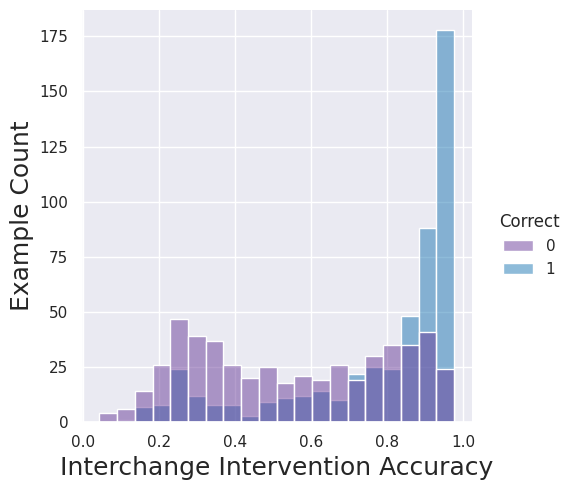

In [ ]:
#@markdown **[Run this block (Optional)]**

#@markdown We can plot the IIA distribution for correct and wrong examples.

#@markdown Examples where the target model predicted wrong generally have lower IIA, i.e., they do not share the same causal mechanisms as the correctly predicted examples.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pred_data = pd.DataFrame([{'Correct': y, 'IIA': x}
                          for x, y in zip(logits, labels)])
sns.set_theme()

ag = sns.displot(pred_data, x='IIA', hue='Correct', bins=20,
                 palette=[sns.color_palette("Paired")[9],
                          sns.color_palette("Paired")[1]])
# set axis label font size to 24
ag.set_xlabels('Interchange Intervention Accuracy', size=18)
_ = ag.set_ylabels('Example Count', size=18)

# Method III: Correctness Probing

In [ ]:
#@markdown **[Run this block]**

#@markdown Helper functions for training and evaluating probes.

from probe import (
    extract_all_hidden_states_batched,
    train_linear_binary_classifier,
    compute_auc_roc_for_all_locations
)
from sklearn.metrics import roc_auc_score


LOCS = {
  'mmlu_id': {
    'loc_last_prompt': 1,
    'loc_last_user_token': 1,
    'loc_new_line': 1,
    'causal_intermediate': 1,
    'causal_output': 1,
    'background_0': 2,
    'background_1': 3,
  },
  'mmlu_ood-option-nato': {
    'loc_last_prompt': 1,
    'loc_last_user_token': 1,
    'loc_new_line': 1,
    'causal_intermediate': 1,
    'causal_output': 1,
    'background_0': 2,
    'background_1': 3,
  },
  'mmlu_ood-option-e': {
    'loc_last_prompt': 1,
    'loc_last_user_token': 1,
    'loc_new_line': 1,
    'causal_intermediate': 1,
    'causal_output': 1,
    'background_0': 2,
    'background_1': 3,
  },
}

In [ ]:
#@markdown **[Run this block]**

import collections
import gc
import json


FOLD_ID = '0'  #@param

task_to_path = {
    'mmlu': {
        # Train
        'id': os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_Meta-Llama-3-8B-Instruct_no_chat_template_0shot_in_distribution_split_{FOLD_ID}.json'),
        # Eval
        'ood-option-nato': os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_Meta-Llama-3-8B-Instruct_no_chat_template_0shot_ood-nato-label_split_{FOLD_ID}.json'),
    }
}
method = 'lr'
num_sample = {'train': 1024, 'val': 512, 'test': 512}
input_max_length = 512

for task in task_to_path:
  TRAINVAL_SPLIT_KEY = f'{task}_id'
  data_split = json.load(open(task_to_path[TRAINVAL_SPLIT_KEY.split('_')[0]]['id']))
  split_to_layer_and_metrics = {}
  for test_split in task_to_path[task]:
    TEST_SPLIT_KEY = f'{task}_{test_split}'
    print(task, TRAINVAL_SPLIT_KEY, TEST_SPLIT_KEY)
    if 'ood' in TEST_SPLIT_KEY:
      data_split['test'] = json.load(
          open(task_to_path[TRAINVAL_SPLIT_KEY.split('_')[0]][TEST_SPLIT_KEY.split('_')[1]]))['test']
    split_to_prompts = {
        s: [p for t in data_split[s]
              for p in data_split[s][t][:num_sample[s]]]
        for s in data_split}
    print(len(split_to_prompts['train']))
    try:
      del hidden_states['test']
      del hidden_states['train']
      del hidden_states['val']
      del hidden_states
    except:
      pass
    gc.collect()
    torch.cuda.empty_cache()
    hidden_states = {
        s: extract_all_hidden_states_batched(
            model, tokenizer,
            split_to_prompts[s], input_max_length,
            token_positions={k: input_max_length - v
                             for k, v in LOCS[TRAINVAL_SPLIT_KEY if s != 'test' else TEST_SPLIT_KEY].items()},
            batch_size=64 if input_max_length < 64 else 4)
        for s in split_to_prompts}
    # Generate labels
    example_labels = {
        s: ['correct'] * len(data_split[s]['correct'][:num_sample[s]]) + ['wrong'] * len(data_split[s]['wrong'][:num_sample[s]])
        for s in num_sample
    }
    # Train probes
    split_type_to_metrics = compute_auc_roc_for_all_locations(hidden_states, example_labels, method)
    split_to_layer_and_metrics[TEST_SPLIT_KEY] = split_type_to_metrics

In [ ]:
#@markdown **[Run this block]**

#@markdown The AUC-ROC of fold 0 should be 0.783 for the last token features (which happen to be causal features) and 0.743 for background features.

#@markdown Averaging the three folds should yield an AUC-ROC of **0.769**, which is slightly higher (+0.04) than the counterfactual simulation results, while averaging background features yields a significantly lower AUC-ROC of 0.733.

for loc in ['loc_last_prompt', 'loc_last_user_token', 'loc_new_line', 'causal_intermediate', 'causal_output', 'background_0', 'background_1']:
  best_layer = sorted(split_to_layer_and_metrics['mmlu_id'], key=lambda layer: split_to_layer_and_metrics['mmlu_id'][layer][loc]['auc_roc'])[-1]
  print(loc, best_layer)
  for split in split_to_layer_and_metrics:
    print(split, split_to_layer_and_metrics[split][best_layer][loc]['auc_roc'])

loc_last_prompt 28
mmlu_id 0.8136672973632812
mmlu_ood-option-nato 0.7827377319335938
loc_last_user_token 28
mmlu_id 0.8136672973632812
mmlu_ood-option-nato 0.7827377319335938
loc_new_line 28
mmlu_id 0.8136672973632812
mmlu_ood-option-nato 0.7827377319335938
causal_intermediate 28
mmlu_id 0.8136672973632812
mmlu_ood-option-nato 0.7827377319335938
causal_output 28
mmlu_id 0.8136672973632812
mmlu_ood-option-nato 0.7827377319335938
background_0 31
mmlu_id 0.7776069641113281
mmlu_ood-option-nato 0.7425880432128906
background_1 17
mmlu_id 0.7652931213378906
mmlu_ood-option-nato 0.7298812866210938


# Method IV: Value Probing

In [ ]:
#@markdown **[Run this block]**

#@markdown Helper functions for parsing causal variable values

model_output_path = "ood-prediction/models/mmlu-0-id_Meta-Llama-3-8B-Instruct_prompt_to_topk_tokens.pt"
MMLU_ID_PROMPT_TO_OUTPUT = torch.load(model_output_path, map_location='cpu', weights_only=True)


def mmlu_parse_variables(prompt):
  def extract_prediction(topk_prob):
    choices = ['A', 'B', 'C', 'D']
    choice_to_prob = {}
    for c in choices:
      ans_dist = [x[1] for x in topk_prob if x[0].strip() == c]
      choice_to_prob[c] = sum(ans_dist, 0)
    return sorted(choice_to_prob, key=choice_to_prob.get, reverse=True)[0]
  dist = MMLU_ID_PROMPT_TO_OUTPUT[prompt]
  return {'label': extract_prediction(dist)}

In [ ]:
#@markdown **[Run this block]**

#@markdown Now, we run value probing on the localized causal features.

#@markdown The AUC-ROC of fold 0 should be around 0.771. Averaging the three folds should yield an AUC-ROC of **0.772**, which achieves the highest AUC-ROC among the four methods.

import json
import re

from probe import (
    extract_all_hidden_states_batched,
    compute_auc_roc_for_all_locations
)

FOLD_ID = '0'  #@param
eval_split = 'ood-nato-label'
method = 'lr'
num_sample = {'train': 1024, 'val': 512, 'test': 512}


data_split = json.load(open(os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_Meta-Llama-3-8B-Instruct_no_chat_template_0shot_in_distribution_split_{FOLD_ID}.json')))
data_split['test'] = json.load(open(os.path.join(DATA_DIR, 'mmlu_task', f'mmlu_{model.name_or_path.split("/")[-1]}_no_chat_template_0shot_{eval_split}_split_{FOLD_ID}.json')))['test']
split_to_prompts = {
    s: [p for t in data_split[s]
          for p in data_split[s][t][:num_sample[s]]]
    for s in data_split}

ckpt_name = f'ood-prediction/models/mmlu-{FOLD_ID}_Meta-Llama-3-8B-Instruct-layer18-block_output-dim4-len256-posf_ep1_example1024.pt' #@param
subspace = torch.load(ckpt_name)
pos_key = 'causal_intermediate'

input_max_length = 512
layer = int(re.search(r'layer(\d+)', ckpt_name).group(1))
print('Using layer %d features.' % layer)
pos = input_max_length - 1
split_to_subspace_features = {}
with torch.no_grad():
  for s in split_to_prompts:
    hidden_states = extract_all_hidden_states_batched(
          model, tokenizer, split_to_prompts[s], input_max_length,
          token_positions={pos_key: input_max_length - 1},
          batch_size=64 if input_max_length < 64 else 4)
    # B * Layer * D
    subspace_features = hidden_states[pos_key][:, layer:layer+1, :] @ subspace[list(subspace.keys())[0]].T.detach().cpu().numpy()
    split_to_subspace_features[s] = {pos_key: subspace_features}
  # Generate labels
  example_labels = {
      s: [mmlu_parse_variables(x)['label'].split('|')[0]
          for x in data_split[s]['correct'][:num_sample[s]]]
      for s in ['train', 'val']
  }
  example_labels['test'] =  [t for t in data_split['test']
                             for p in data_split['test'][t][:num_sample['test']]]
  # Train probes
  split_to_layer_and_metrics = compute_auc_roc_for_all_locations(
      split_to_subspace_features, example_labels, method)
print('Test set AUC-ROC:', split_to_layer_and_metrics[0][pos_key]['auc_roc'])

Using layer 18 features.
4 ['C', 'A', 'B', 'D']
0 causal_intermediate
Training set accuracy: 0.9765625
Validation set accuracy: 0.982421875
Test set AUC-ROC: 0.7713356018066406
